In [ ]:
import cv2
import numpy as np

img = cv2.imread("sources/emblema.jpg")
#img = cv2.imread("sources/Geeks.png")
#img = cv2.imread("sources/caras.jpg")

print(len(img[0]))

print(img.shape)

img2 = cv2.resize(img,(900, 545), interpolation=cv2.INTER_BITS)

gauss = cv2.GaussianBlur(img2,(5,5),3)


hpf = img2 - gauss



cv2.imshow("img", img)
cv2.imshow("img2", img2)
cv2.imshow("hpf", hpf)
cv2.imshow("gaus", gauss)
cv2.waitKey()
cv2.destroyAllWindows()



# Conceptualizing Haar cascades

Cuando hablamos de clasificar objetos y rastrear su ubicación, ¿qué es exactamente lo que esperamos identificar? ¿Qué constituye una parte reconocible de un objeto?

Las imágenes fotográficas, incluso desde una cámara web, pueden contener muchos detalles para nuestro placer visual (humano). Sin embargo, el detalle de la imagen tiende a ser inestable con respecto a las variaciones en la iluminación, el ángulo de visión, la distancia de visión, el movimiento de la cámara y el ruido digital. Además, incluso las diferencias reales en los detalles físicos podrían no interesarnos para la clasificación. A Joseph Howse, uno de los autores de este libro, se le enseñó en la escuela que no hay dos copos de nieve iguales bajo un microscopio. Afortunadamente, cuando era un niño canadiense, ya había aprendido a reconocer copos de nieve sin un microscopio, ya que las similitudes son más obvias a granel.

Por lo tanto, tener algunos medios para abstraer los detalles de la imagen es útil para producir resultados estables de clasificación y seguimiento. Las abstracciones se llaman características, que se dice que se extraen de los datos de la imagen. Debe haber muchas menos características que píxeles, aunque cualquier píxel puede influir en múltiples características. Un conjunto de entidades se representa como un vector (conceptualmente, un conjunto de coordenadas en un espacio multidimensional), y el nivel de similitud entre dos imágenes se puede evaluar en función de alguna medida de la distancia entre los vectores de características correspondientes de las imágenes.

Más adelante, en el Capítulo 6, Recuperación de imágenes y búsqueda mediante descriptores de imágenes, exploraremos varios tipos de características, así como formas avanzadas de describir y hacer coincidir conjuntos de entidades.

Las características similares a Haar son un tipo de característica que a menudo se aplica a la detección de rostros en tiempo real. Se utilizaron por primera vez para este propósito en el artículo Robust Real-Time Face Detection, de Paul Viola y Michael Jones (International Journal of Computer Vision 57 (2), 137-154, Kluwer Academic Publishers, 2001). Una versión electrónica de este documento está disponible en http://comp3204.ecs.soton.ac.uk/cw/viola04ijcv.pdf.

Cada característica similar a Haar describe el patrón de contraste entre las regiones de imagen adyacentes. Por ejemplo, las aristas, los vértices y las líneas finas generan cada uno un tipo de entidad. Algunas características son distintivas en el sentido de que típicamente ocurren en una cierta clase de objeto (como una cara) pero no en otros objetos. Estas características distintivas se pueden organizar en una jerarquía, llamada cascada, en la que las capas más altas contienen características de mayor distinción, lo que permite a un clasificador rechazar rápidamente los sujetos que carecen de estas características. Si un sujeto es una buena combinación para las características de la capa superior, entonces el clasificador también considera las características de la capa inferior para eliminar más falsos positivos.

Para cualquier sujeto dado, las características pueden variar dependiendo de la escala de la imagen y el tamaño del vecindario (la región de píxeles cercanos) en el que se evalúa el contraste. El tamaño del vecindario se llama tamaño de ventana. Para hacer que un clasificador en cascada de Haar sea invariante de escala o, en otras palabras, robusto a los cambios de escala, el tamaño de la ventana se mantiene constante, pero las imágenes se reescalan varias veces; Por lo tanto, en algún nivel de reescalado, el tamaño de un objeto (como una cara) puede coincidir con el tamaño de la ventana. Juntas, la imagen original y las imágenes reescaladas se denominan pirámide de imágenes, y cada nivel sucesivo en esta pirámide es una imagen reescalada más pequeña. OpenCV proporciona un clasificador invariante de escala que puede cargar una cascada de Haar desde un archivo XML en un formato determinado. Internamente, este clasificador convierte cualquier imagen dada en una pirámide de imágenes.

Las cascadas de Haar, tal como se implementan en OpenCV, no son robustas a los cambios en la rotación o la perspectiva. Por ejemplo, una cara al revés no se considera similar a una cara erguida y una cara vista de perfil no se considera similar a una cara vista desde el frente. Una implementación más compleja e intensiva en recursos podría mejorar la robustez de una cascada de Haar a la rotación al considerar múltiples transformaciones de imágenes, así como múltiples tamaños de ventana. Sin embargo, nos limitaremos a la implementación en OpenCV.


## Obtención de datos en cascada de Haar

La instalación de OpenCV 5 debe contener una subcarpeta llamada . La ruta a esta carpeta se almacena en una variable OpenCV denominada . `datacv2.data.haarcascades`

La carpeta contiene archivos XML que pueden ser cargados por una clase OpenCV llamada . Una instancia de esta clase interpreta un archivo XML determinado como una cascada de Haar, que proporciona un modelo de detección para un tipo de objeto, como una cara. Puede detectar este tipo de objeto en cualquier imagen. Como de costumbre, podríamos obtener una imagen fija de un archivo, o podríamos obtener una serie de fotogramas de un archivo de video o una cámara de video. `datacv2.CascadeClassifiercv2.CascadeClassifier`

Desde la carpeta, usaremos los siguientes archivos en cascada: `data`


`
haarcascade_frontalface_default.xml
haarcascade_eye.xml
`

Como sus nombres sugieren, estas cascadas son para detectar rostros y ojos. Requieren una visión frontal y vertical del sujeto. Los usaremos más adelante cuando construyamos un detector facial.

Si tienes curiosidad sobre cómo se generan estos archivos en cascada, puedes encontrar más información en el libro de Joseph Howse, OpenCV 4 for Secret Agents (Packt Publishing, 2019), específicamente en el Capítulo 3, Entrenando una alarma inteligente para reconocer al villano y su gato. Con mucha paciencia y una computadora razonablemente potente, puede hacer sus propias cascadas y entrenarlas para varios tipos de objetos.


## Uso de OpenCV para realizar la detección de rostros
con `cv2.CascadeClassifier`, hay poca diferencia  si realizamos la detección de rostros en una imagen fija o en una transmisión de video. El último es solo una versión secuencial del primero: la detección de rostros en un video es simplemente detección de rostros aplicada a cada cuadro. Naturalmente, con técnicas más avanzadas, sería posible rastrear una cara detectada continuamente a través de múltiples cuadros y determinar que la cara es la misma en cada cuadro. Sin embargo, es bueno saber que un enfoque secuencial básico también funciona.

Sigamos adelante y detectemos algunas caras.

### Realización de la detección de rostros en una imagen fija
La primera y más básica forma de realizar la detección de rostros es cargar una imagen y detectar rostros en ella. Para que el resultado sea visualmente significativo, dibujaremos rectángulos alrededor de las caras en la imagen original. Recordando que el detector de rostros está diseñado para caras verticales y frontales, usaremos una imagen de una fila de personas, específicamente leñadores, de pie hombro con hombro y mirando hacia el fotógrafo o espectador.

Sigamos adelante y creemos el siguiente script básico para realizar la detección de rostros:

In [ ]:
import cv2
cara_cascadas = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
print(cv2.data.haarcascades)

img = cv2.imread("sources/caras.jpg")
cv2.imshow('caras detectadas!', img)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow('caras detectadas!', gris)

caras = cara_cascadas.detectMultiScale(gris, 1.08, 3)

print(caras)

for (x, y, w, h) in caras:
    img2 = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255, 0), 2)
    
cv2.namedWindow('caras detectadas!')
cv2.imshow('caras detectadas!', img2)
cv2.imwrite('sources/caras detectadas.png', img2)


cv2.waitKey(0)
cv2.destroyAllWindows()

Repasemos el código anterior en pequeños pasos. Primero, usamos la importación obligatoria `cv2` que encontrará en cada guión de este libro. Luego, declaramos una variable `cara_cascadas`, que es un objeto `CascadeClassifier` que carga una cascada para la detección de rostros:

`cara_cascadas = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')`

Luego cargamos nuestro archivo de imagen `cv2.imread` y lo convertimos en escala de grises porque `CascadeClassifier`, como muchos de los clasificadores de OpenCV, espera imágenes en escala de grises. (Si intentamos usar una imagen en color, la convertiremos internamente a escala de grises de todos modos). El siguiente paso, `cara_cascadas.detectMultiScale` , es donde realizamos la detección de rostros real:

`
img = cv2.imread('../images/woodcutters.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.08, 5)
`

Los parámetros de `detectMultiScale` incluye `scaleFactor` y `minNeighbors`. El argumento `scaleFactor `, que debe ser mayor que 1.0, determina la relación de reducción de escala de la imagen en cada iteración del proceso de detección de rostros. Como discutimos anteriormente en la sección Conceptualización de las cascadas de Haar, esta reducción de escala está destinada a lograr la invariancia de escala al hacer coincidir varias caras con el tamaño de la ventana. El argumento `minNeighbors` es el número mínimo de detecciones superpuestas necesarias para conservar un resultado de detección. Normalmente, esperamos que una cara pueda detectarse en múltiples ventanas superpuestas, y un mayor número de detecciones superpuestas nos hace estar más seguros de que la cara detectada es realmente una cara.


El valor devuelto por la operación de detección es una lista de tuplas que representan los rectángulos faciales. La función `cv2.rectangle` de OpenCV nos permite dibujar rectángulos en las coordenadas especificadas. **X** y **Y** representan las coordenadas izquierda y superior, mientras que **W** y **H** representan el ancho y la altura del rectángulo de la cara. Dibujamos rectángulos cian alrededor de todas las caras que encontramos haciendo un bucle a través de la variable `faces`, asegurándonos de usar la imagen original para dibujar, no la versión gris:

`
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255255, 0), 2)
`

Por último, llamamos `cv2.imshow` para mostrar la imagen procesada resultante y llamamos `cv2.imwrite` para guardarla. Como de costumbre, para evitar que la ventana de imagen se cierre automáticamente, insertamos una llamada a `waitKey`, que regresa cuando el usuario presiona cualquier tecla:

`
cv2.imshow('Woodcutters Detected!', img)
cv2.imwrite('./woodcutters_detected.pngpng', img)
cv2.waitKey(0)
`

Y ahí vamos, tres miembros de la banda de leñadores han sido detectados en nuestra imagen, como se muestra en la siguiente captura de pantalla:

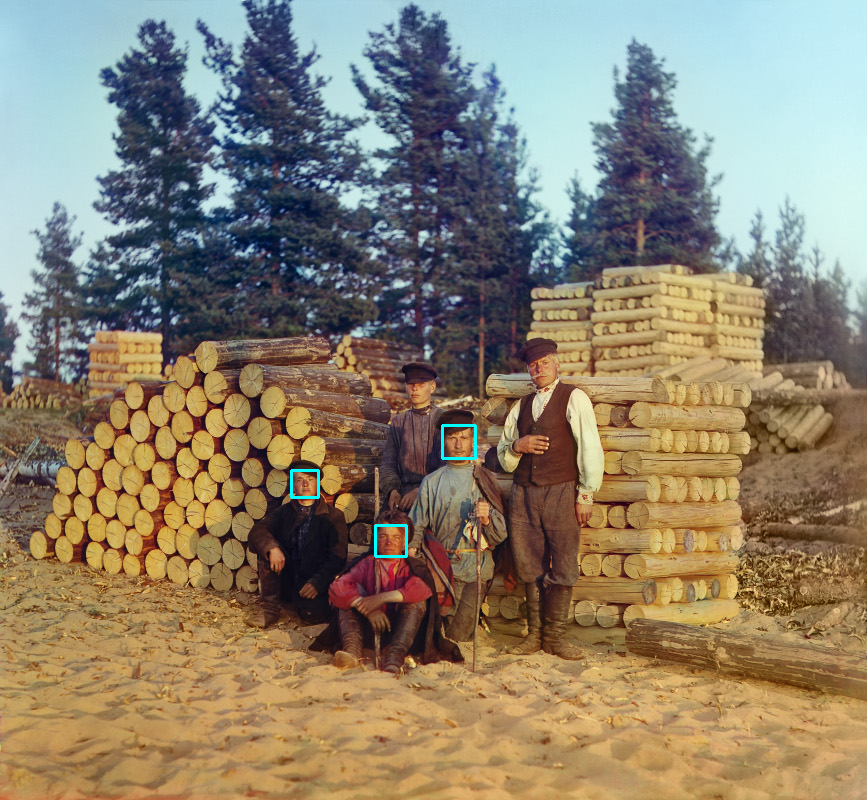


Aquí, no tenemos detecciones de falsos positivos; Los tres rectángulos realmente son caras de leñadores. Sin embargo, tenemos dos falsos negativos (leñadores cuyas caras no fueron detectadas). Intente ajustar los parámetros de `face_cascade.detectMultiScale` para ver cómo cambian los resultados. Luego, pasemos a un ejemplo más interactivo.


### Realizar la detección de rostros en un vídeo

Ahora entendemos cómo realizar la detección de rostros en una imagen fija. Como se mencionó anteriormente, podemos repetir el proceso de detección de rostros en cada fotograma de un video (ya sea una alimentación de cámara o un archivo de video pregrabado).

El siguiente script abrirá una alimentación de cámara, leerá un cuadro, examinará ese marco en busca de caras y buscará ojos dentro de las caras detectadas. Finalmente, dibujará rectángulos azules alrededor de las caras y rectángulos verdes alrededor de los ojos. Aquí está el guión en su totalidad:


In [ ]:
import cv2
caras_en_cascada = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
print(caras_en_cascada)

ojos_en_cascada = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')
print(ojos_en_cascada)

camara =  cv2.VideoCapture(1)
print(camara)

while (cv2.waitKey(1) == -1):
    success, frame = camara.read()
    
    if success:
        
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caras = caras_en_cascada.detectMultiScale(gris, 1.3, 3, minSize=(120, 120))
        
        for (x, y, w, h) in caras:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255,0,0), 2)
            
            roi_gris = gris[y:y+h, x:x+w]
            ojos = ojos_en_cascada.detectMultiScale(roi_gris, 1.11, 3, minSize=(40,40))
            
            for (ox, oy, ow, oh) in ojos:
                cv2.rectangle(frame, (x + ox, y + oy), (x + ox + ow, y + oy + oh), (0,255,0), 2)
        
        cv2.imshow('Face Detection', frame)

cv2.destroyAllWindows()

Dividamos la muestra anterior en partes más pequeñas y digeribles:



1. Como de costumbre, importamos el módulo cv2. Después de eso, inicializamos dos objetos CascadeClassifier, uno para rostros y otro para ojos:
```python
face_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_eye.xml')`
```

2. Como en la mayoría de nuestros scripts interactivos, abrimos una transmisión de cámara y comenzamos a iterar sobre los cuadros. Continuamos hasta que el usuario presione cualquier tecla. Cada vez que capturamos con éxito un cuadro, lo convertimos a escala de grises como nuestro primer paso para procesarlo:

```python
camera = cv2.VideoCapture(0)
 while (cv2.waitKey(1) == -1):
     success, frame = camera.read()
     if success:
         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
```


3. Detectamos rostros con el método `detectMultiScale` de nuestro detector de rostros. Como hemos hecho anteriormente, usamos los argumentos `scaleFactor` y `minNeighbors`. También usamos el argumento minSize para especificar un tamaño mínimo de una cara, específicamente 120x120. No se intentará detectar caras más pequeñas que esta. (Asumiendo que nuestro usuario está sentado cerca de la cámara, es seguro decir que la cara del usuario tendrá más de 120x120 píxeles). Aquí está la llamada para detectar MultiScale:
```python
faces = face_cascade.detectMultiScale(
    gray, 1.3, 5, minSize=(120, 120))
```

4. Iteramos sobre los rectángulos de las caras detectadas. Dibujamos un borde azul alrededor de cada rectángulo en la imagen en color original. Luego, dentro de la misma región rectangular de la imagen en escala de grises, realizamos la detección de ojos:

```python
for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(
        roi_gray, 1.1, 5, minSize=(40, 40))
```        
   El detector de ojos es un poco menos preciso que el detector de rostros. Es posible que vea sombras, partes de los marcos de los anteojos u otras regiones de la cara falsamente detectadas como ojos. Para mejorar los resultados, puede intentar definir `roi_gray` como una región más pequeña de la cara, ya que podemos hacer una buena suposición sobre la ubicación de los ojos en una cara erguida. También puede intentar usar un argumento `maxSize` para evitar falsos positivos que son demasiado grandes para ser ojos. Además, puede ajustar `minSize` y `maxSize` para que las dimensiones sean proporcionales a **w** y **h**, el tamaño de la cara detectada. Como ejercicio, siéntase libre de experimentar con cambios en estos y otros parámetros.
    
5. Recorremos los rectángulos de ojos resultantes y dibujamos contornos verdes alrededor de ellos:
```python
for (ex, ey, ew, eh) in eyes:
    cv2.rectangle(frame, (x+ex, y+ey),
                  (x+ex+ew, y+ey+eh), (0, 255, 0), 2)
```

6. Finalmente, mostramos el cuadro resultante en la ventana:
```python
cv2.imshow('Face Detection', frame)
```
    Ejecute el script. Si nuestros detectores producen resultados precisos y si alguna cara está dentro del campo de visión de la cámara, debería ver un rectángulo azul alrededor de la cara y un rectángulo verde alrededor de cada ojo, como se muestra en esta captura de pantalla:
    
    
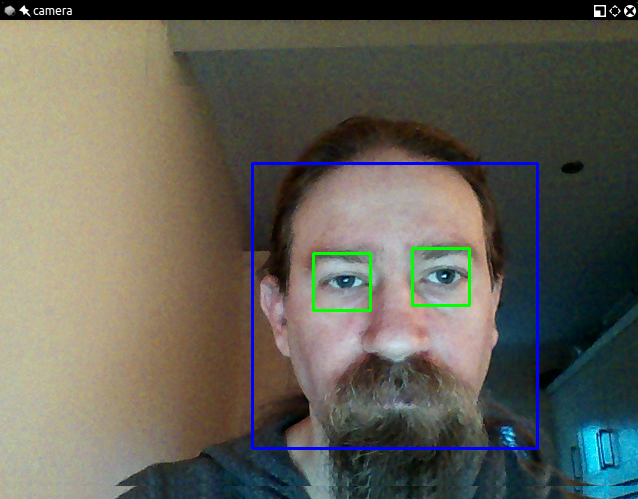

Experimente con esta secuencia de comandos para ver cómo funcionan los detectores de cara y ojos en diversas condiciones. Pruebe con una habitación más luminosa o más oscura. Si usa anteojos, intente quitárselos. Pruebe las caras de varias personas y varias expresiones. Ajuste los parámetros de detección en el script para ver cómo afectan los resultados. Cuando esté satisfecho, consideremos qué más podemos hacer con las caras en OpenCV.


### Realización de reconocimiento facial

La detección de rostros es una característica fantástica de OpenCV y que constituye la base para una operación más avanzada: el reconocimiento facial. ¿Qué es el reconocimiento facial? Es la capacidad de un programa, dada una imagen o un video que contiene el rostro de una persona, para identificar a esa persona. Una de las formas de lograr esto (y el enfoque adoptado por OpenCV) es entrenar el programa alimentándolo con un conjunto de imágenes clasificadas (una base de datos facial) y realizar un reconocimiento basado en las características de esas imágenes.

Otra característica importante del módulo de reconocimiento facial de OpenCV es que cada reconocimiento tiene una puntuación de confianza, lo que nos permite establecer umbrales en aplicaciones de la vida real para limitar la incidencia de identificaciones falsas.

Comencemos desde el principio; para realizar el reconocimiento facial, necesitamos rostros para reconocer. Cumplimos con este requisito de dos maneras: suministramos las imágenes nosotros mismos u obtenemos bases de datos de rostros disponibles gratuitamente. Un gran directorio de bases de datos de rostros está disponible en línea en http://www.face-rec.org/databases/. Aquí hay algunos ejemplos notables del directorio:

> * Base de datos de rostros de Yale (Yalefaces): http://vision.ucsd.edu/content/yale-face-database
> * Base de datos facial B extendida de Yale: http://vision.ucsd.edu/content/extended-yale-face-database-b-b
> * Base de datos de rostros (de AT&T Laboratories Cambridge): https://cam-orl.co.uk/facedatabase.html.


Si entrenamos un reconocedor de rostros en estas muestras, entonces tendríamos que ejecutar el reconocimiento facial en una imagen que contenga el rostro de una de las personas muestreadas. Este proceso puede ser educativo, pero quizás no tan satisfactorio como proporcionar nuestras propias imágenes. Probablemente haya pensado lo mismo que muchos estudiantes de visión artificial: me pregunto si puedo escribir un programa que reconozca mi rostro con cierto grado de confianza. De hecho, usted puede y pronto lo hará!

### Generando los datos para el reconocimiento facial

Avancemos y escribamos un script que genere esas imágenes para nosotros. Unas pocas imágenes que contengan diferentes expresiones es todo lo que necesitamos, pero es preferible que las imágenes de entrenamiento sean cuadradas y todas del mismo tamaño. Nuestro script de muestra usa un tamaño de 200x200, pero la mayoría de los conjuntos de datos disponibles gratuitamente tienen imágenes más pequeñas que esto.

Aquí está el script en sí:



In [ ]:
import cv2
import os
folder_de_salida = 'sources/data/out/steve'

if not os.path.exists(folder_de_salida):
    os.makedirs(folder_de_salida)

caras_en_cascada = cv2.CascadeClassifier(
    f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')

camera = cv2.VideoCapture(1)

count = 0

while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    
    if success:
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caras = caras_en_cascada.detectMultiScale(gris, 1.3, 3, minSize=(120, 120))
        
        for (x, y, w, h) in caras:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            imagen_cara = cv2.resize(gris[y:y+h, x:x+w], (200, 200))
            archivoCara = "%s/%d.jpg" % (folder_de_salida, count)
            print(archivoCara)
            cv2.imwrite(archivoCara, imagen_cara)
            count += 1
            
        cv2.imshow("Captura Caras...", frame)
        
        
cv2.destroyAllWindows()

img = cv2.imread("sources/data/out/jonathan/0.jgc")
cv2.imshow("ss", img)


cv2.destroyAllWindows()


Aquí, estamos generando imágenes de muestra basándonos en nuestro nuevo conocimiento sobre cómo detectar un rostro en una transmisión de video. Estamos detectando un rostro, recortando esa región del marco convertido en escala de grises, redimensionándolo a 200x200 píxeles y guardándolo como un archivo JGC con un nombre en una carpeta particular (en este caso, **jgc**, una de las iniciales de los autores ; puede usar sus propias iniciales). Como muchas de nuestras aplicaciones con ventanas, esta se ejecuta hasta que el usuario presiona cualquier tecla.

La variable de recuento está presente porque necesitábamos nombres progresivos para las imágenes. Ejecute el script durante unos segundos, cambie su expresión facial varias veces y verifique la carpeta de destino que especificó en el script. Encontrará una serie de imágenes de su cara, atenuadas, redimensionadas y nombradas con el formato <count>.jgc.

Modifique la variable carpeta_salida para que coincida con su nombre. Por ejemplo, puede elegir '../data/at/my_name'. Ejecute el script, espere a que detecte su rostro en varios fotogramas (digamos, 20 o más) y luego presione cualquier tecla para salir. Ahora, modifique la variable carpeta_salida nuevamente para que coincida con el nombre de un amigo a quien también desea reconocer. Por ejemplo, puede elegir '../data/out/nombre_de_su_Amigo'. No cambie la parte base de la carpeta (en este caso, '../data/out') porque más adelante, en la sección Cargando los datos de entrenamiento para el reconocimiento facial, escribiremos código que cargue las imágenes de entrenamiento de todos los subcarpetas de esta carpeta base. Pídele a tu amigo que se siente frente a la cámara, vuelve a ejecutar el script, deja que detecte la cara de tu amigo en varios fotogramas y luego sal. Repita este proceso para cualquier persona adicional que desee reconocer.

Pasemos ahora a tratar de reconocer la cara del usuario en un video. ¡Esto va a ser divertido!
    

### Eligiendo un algoritmo de reconocimiento
    
OpenCV 5 implementa tres algoritmos diferentes para reconocer rostros: Eigenfaces, Fisherfaces e histogramas de patrones binarios locales (LBPH). Eigenfaces y Fisherfaces se derivan de un algoritmo de propósito más general llamado Análisis de Componentes Principales (PCA). Para obtener una descripción detallada de los algoritmos, consulte los siguientes enlaces:
    
> * **PCA:** un tutorial sobre el análisis de componentes principales (2013), de Jonathon Shlens, está disponible en http://arxiv.org/pdf/1404.1100v1.pdf. Este algoritmo fue inventado en 1901 por Karl Pearson, y el artículo original, On Lines and Planes of Closest Fit to Systems of Points in Space, está disponible en http://pca.narod.ru/pearson1901.pdf.

> * **Eigenfaces:** El artículo Eigenfaces for Recognition (1991), de Matthew Turk y Alex Pentland, está disponible en http://www.cs.ucsb.edu/~mturk/Papers/jcn.pdf.

> * **Fisherfaces:** The seminal paper The Use of Multiple Measurements in Taxonomic Problems (1936), de R. A. Fisher, está disponible en http://onlinelibrary.wiley.com/doi/10.1111/j.1469-1809.1936.tb02137.x/pdf.

> * **Local Binary Pattern** binario local: el primer artículo que describe este algoritmo es Evaluación del rendimiento de las medidas de textura con clasificación basada en la discriminación de distribuciones de Kullback (1994), de T. Ojala, M. Pietikainen y D. Harwood. Está disponible en https://ieeexplore.ieee.org/document/576366.


### Cargando los datos de entrenamiento para el reconocimiento
    
Independientemente del algoritmo de reconocimiento facial que elijamos, podemos cargar las imágenes de entrenamiento de la misma manera. Anteriormente, en la sección Generación de los datos para el reconocimiento facial, generamos imágenes de entrenamiento y las guardamos en carpetas organizadas según los nombres o iniciales de las personas. Por ejemplo, la siguiente estructura de carpetas podría contener imágenes faciales de muestra de los autores de este libro, Joseph Howse (jh) y Joe Minichino (jm):

```
    ../
  data/
    at/
      jh/
      jm/
    
```
    

Vamos a escribir un script que cargue estas imágenes y las etiquete de forma que los reconocedores de caras de OpenCV las entiendan. Para trabajar con el sistema de archivos y los datos, utilizaremos el módulo **os** de la biblioteca estándar de Python, así como los módulos cv2 y numpy. Vamos a crear un script que comience con las siguientes sentencias import:
    
    
```python
import os
import cv2
import numpy
```

Añadamos la siguiente función **read_images**, que recorre los subdirectorios de un directorio, carga las imágenes y muestra cada una de ellas con fines informativos para el usuario, las redimensiona a un tamaño especificado y coloca las imágenes redimensionadas en una lista. El orden de esta lista no tiene importancia en sí mismo, pero, al mismo tiempo, nuestra función construye dos listas correspondientes que describen las imágenes: en primer lugar, una lista correspondiente de nombres o iniciales de personas (basada en los nombres de las subcarpetas) y, en segundo lugar, una lista correspondiente de etiquetas o ID numéricos asociados a las imágenes cargadas. Por ejemplo, **jh** podría ser un nombre y **0** podría ser la etiqueta de todas las imágenes cargadas desde la subcarpeta `jh`. Por último, la función convierte las listas de imágenes y etiquetas en matrices NumPy y devuelve tres variables: la lista de nombres, la matriz NumPy de imágenes y la matriz NumPy de etiquetas. He aquí la implementación de la función:
    
```python
def read_images(path, image_size):
    names = []
    training_images, training_labels = [], []
    label = 0
    for dirname, subdirnames, filenames in os.walk(path):
        for subdirname in subdirnames:
            names.append(subdirname)
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                img = cv2.imread(os.path.join(subject_path, filename),
                                 cv2.IMREAD_GRAYSCALE)
                if img is None:
                    # The file cannot be loaded as an image.
                    # Skip it.
                    continue
                img = cv2.resize(img, image_size)
                cv2.imshow('training', img)
                cv2.waitKey(5)
                training_images.append(img)
                training_labels.append(label)
            label += 1
    training_images = numpy.asarray(training_images, numpy.uint8)
    training_labels = numpy.asarray(training_labels, numpy.int32)
    return names, training_images, training_labels
```
    

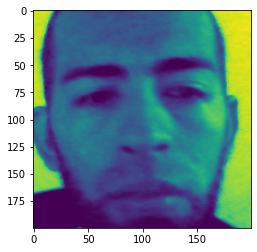

In [1]:
import os
import cv2
import numpy

import matplotlib.pyplot as plt
import matplotlib.image as img


def lectura_imagenes(ruta, tamanio_imagen):
    nombres = []
    imagenes_entrenamiento, etiquetas_entrenamiento = [], []
    
    etiqueta = 0
    
    
    #os.walkRuta permite conocer las carpetas internas a partir de esa ruta
    for nombreDir, subNombreDirs, nombreArchivos in os.walk(ruta):
        for subNombreDir in subNombreDirs:
            nombres.append(subNombreDir)
            ruta_archivos = os.path.join(nombreDir, subNombreDir)
            
            for nombreArchivo in os.listdir(ruta_archivos):
                #abrir el archivo
                img = cv2.imread(os.path.join(ruta_archivos, nombreArchivo), cv2.IMREAD_GRAYSCALE)
                #cv2.imshow(f'training{nombreArchivo}', img)
                
                if img is None:
                    # The file cannot be loaded as an image.
                    # Skip it.
                    continue
                
                img = cv2.resize(img, tamanio_imagen)
                cv2.imshow("training", img)
                cv2.waitKey(5)
                imagenes_entrenamiento.append(img)
                etiquetas_entrenamiento.append(etiqueta)
            
            etiqueta+=1
            
    imagenes_entrenamiento = numpy.asarray(imagenes_entrenamiento, numpy.uint8)
    etiquetas_entrenamiento = numpy.asarray(etiquetas_entrenamiento, numpy.int32)
    return nombres, imagenes_entrenamiento, etiquetas_entrenamiento
    


path_to_training_images = 'sources/data/out/'
training_image_size = (200, 200)

image = img.imread(f'{path_to_training_images}jonathan/0.jpg')
#nombres, imagenes_entrenamiento, Etiquetas_entrenamiento = 
nombres, imagenesEntrenamiento, etiquetasEntrenamiento = lectura_imagenes(path_to_training_images, training_image_size)

plt.imshow(image)
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()


modelo = cv2.face.EigenFaceRecognizer_create()
modelo.train(imagenesEntrenamiento, etiquetasEntrenamiento)

caras_en_cascada = cv2.CascadeClassifier(
    f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')


camera = cv2.VideoCapture(1)


while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    
    if success:
        caras = caras_en_cascada.detectMultiScale(frame, 1.3, 3)
        
        for (x, y, w, h) in caras:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            roi_gris = gris[x:x+w, y:y+h]
            
            if roi_gris.size == 0:
                # The ROI is empty. Maybe the face is at the image edge.
                # Skip it.
                continue
            
            roi_gris = cv2.resize(roi_gris, training_image_size)
            etiqueta, confianza = modelo.predict(roi_gris)
            texto = '%s, confianza=%.2f' % (nombres[etiqueta], confianza)
            cv2.putText(frame, texto, (x, y -20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            
        cv2.imshow("Reconocimiento Caras...", frame)
        
        
cv2.destroyAllWindows()


Llamemos a nuestra función **read_images** añadiendo código como el siguiente:

```python
path_to_training_images = '../data/at'
training_image_size = (200, 200)
names, training_images, training_labels = read_images(
    path_to_training_images, training_image_size)
```

Edita la variable **path_to_training_images** del bloque de código anterior para asegurarte de que coincide con la carpeta base de las variables output_folder que definiste anteriormente en el código de la sección Generación de los datos para el reconocimiento facial.

Hasta ahora, tenemos datos de entrenamiento en un formato útil, pero aún no hemos creado un reconocedor de caras ni hemos realizado ningún entrenamiento. Lo haremos en la siguiente sección, donde continuamos con la implementación del mismo script.


### Performing face recognition with Eigenfaces
Ahora que tenemos una matriz de imágenes de entrenamiento y una matriz con sus etiquetas, podemos crear y entrenar un reconocedor facial con sólo dos líneas de código más:

```python
model = cv2.face.EigenFaceRecognizer_create()
model.train(training_images, training_labels)
```

¿Qué hemos hecho aquí? Hemos creado el reconocedor facial Eigenfaces con la función **cv2.EigenFaceRecognizer_create** de OpenCV, y hemos entrenado el reconocedor pasándole las matrices de imágenes y etiquetas (IDs numéricos). Opcionalmente, podríamos haber pasado dos argumentos a **cv2.EigenFaceRecognizer_create**:

> * **num_componentes**: Este es el número de componentes a mantener para el PCA.
> * **threshold**: Es un valor de coma flotante que especifica un umbral de confianza. Las caras con una puntuación de confianza por debajo del umbral serán descartadas. Por defecto, el umbral es el valor máximo en coma flotante para que no se descarte ninguna cara.


Una vez entrenado este modelo, podríamos guardarlo en un archivo utilizando código como model.write('mi_modelo.xml'). Más tarde (por ejemplo, en otro script), podríamos saltarnos el paso de entrenamiento y simplemente cargar el modelo de pre-entrenamiento desde el archivo utilizando código como model.read('mi_modelo.xml'). Sin embargo, para nuestra sencilla demostración, sólo entrenaremos y probaremos el modelo en un script sin guardar el modelo en un archivo.

Para probar este reconocedor, vamos a utilizar un detector de caras y un vídeo de una cámara. Como hemos hecho en scripts anteriores, podemos utilizar la siguiente línea de código para inicializar el detector de caras:


```python
face_cascade = cv2.CascadeClassifier(
    f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
```

El siguiente código inicializa la alimentación de la cámara, itera sobre los fotogramas (hasta que el usuario pulsa cualquier tecla) y realiza la detección y el reconocimiento facial en cada fotograma:


```python
camera = cv2.VideoCapture(0)
while (cv2.waitKey(1) == -1):
    success, frame = camera.read()
    if success:
        faces = face_cascade.detectMultiScale(frame, 1.3, 5)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            roi_gray = gray[x:x+w, y:y+h]
            if roi_gray.size == 0:
                # The ROI is empty. Maybe the face is at the image edge.
                # Skip it.
                continue
            roi_gray = cv2.resize(roi_gray, training_image_size)
            label, confidence = model.predict(roi_gray)
            text = '%s, confidence=%.2f' % (names[label], confidence)
            cv2.putText(frame, text, (x, y - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2.imshow('Face Recognition', frame)     
```

Veamos las funciones más importantes del bloque de código anterior. Para cada cara detectada, la convertimos y redimensionamos de modo que tengamos una versión en escala de grises que coincida con el tamaño esperado (en este caso, 200x200 píxeles según lo definido por la variable training_image_size en la sección anterior, Carga de los datos de entrenamiento para el reconocimiento facial). A continuación, pasamos la cara redimensionada en escala de grises a la función de predicción del reconocedor facial. Ésta devuelve una etiqueta y una puntuación de confianza. Buscamos el nombre de la persona correspondiente a la etiqueta numérica de esa cara. (Recuerda que creamos la matriz de nombres en la sección anterior, Carga de los datos de entrenamiento para el reconocimiento facial). Dibujamos el nombre y la puntuación de confianza en texto azul encima de la cara reconocida. Después de iterar sobre todas las caras detectadas, mostramos la imagen anotada.

Hemos tomado un enfoque simple para la detección y reconocimiento de caras, y sirve al propósito de permitirle tener una aplicación básica en ejecución y entender el proceso de reconocimiento de caras en OpenCV 5. Para mejorar este enfoque y hacerlo más robusto, usted podría tomar medidas adicionales, tales como alinear y rotar correctamente las caras detectadas para que la precisión del reconocimiento sea máxima.

Cuando ejecutes el script, deberías ver algo similar a la siguiente captura de pantalla:

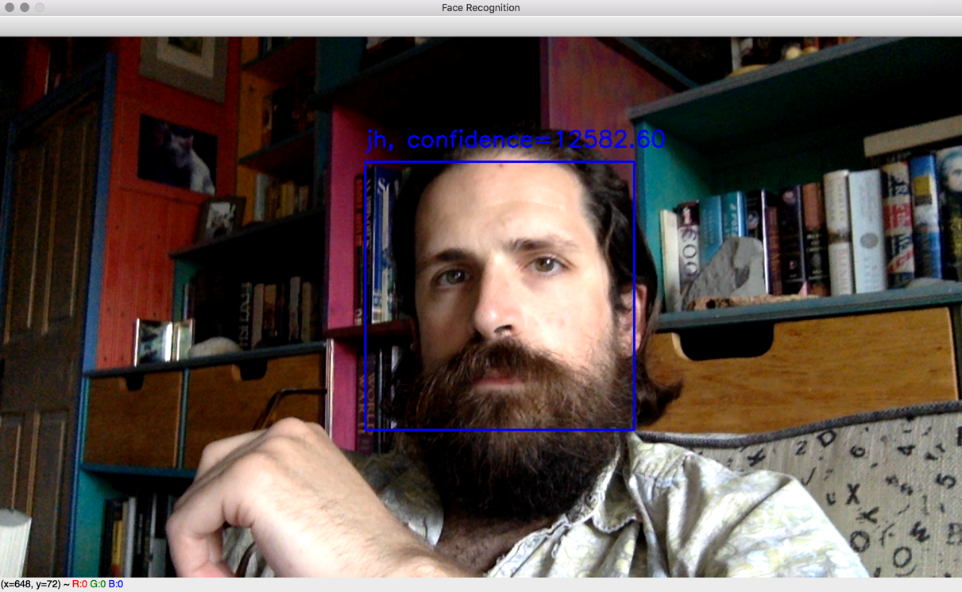

A continuación, vamos a considerar cómo adaptaríamos este script para sustituir Eigenfaces por otro algoritmo de reconocimiento facial.